# Lecture 12 – Data 100, Spring 2025

Data 100, Spring 2025

[Acknowledgments Page](https://ds100.org/sp25/acks/)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Multiple Linear Regression

Let's load in a new dataset. This is aggregate per-player data from the 2018-19 NBA season, downloaded from [Kaggle](https://www.kaggle.com/schmadam97/nba-regular-season-stats-20182019).

In [3]:
nba = pd.read_csv('data/nba18-19.csv', index_col=0)
nba.index.name = None # Drops name of index (players are ordered by rank)

In [4]:
nba.head(5)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


<br/>

We are interested in predicting the number of points, `PTS`, an athlete will score in a basketball game this season.

Suppose we want to fit a linear model by using some characteristics, or **features** of a player. Specifically, we'll focus on field goals, assists, and 3-point attempts.

- `FG`, the number of (2-point) field goals per game
- `AST`, the average number of assists per game, and
- `3PA`, the number of 3-point field goals attempted per game

This is how we express that model:

$$
\hat{y}
=
\theta_0 + 
\theta_1 \cdot \textbf{FG} +
\theta_2 \cdot \textbf{AST} +
\theta_3 \cdot \textbf{3PA} 
$$

In [5]:
nba[['FG', 'AST', '3PA', 'PTS']]

,FG,AST,3PA,PTS
1,1.8,0.6,4.1,5.3
2,0.4,0.8,1.5,1.7
3,1.1,1.9,2.2,3.2
4,6.0,1.6,0.0,13.9
5,3.4,2.2,0.2,8.9
...,...,...,...,...
528,4.0,0.8,0.0,11.5
529,3.1,0.9,0.0,7.8
530,3.6,1.1,0.0,8.9
530,3.4,0.8,0.0,8.5


<br/>
In the lecture, we saw that the predictions for the entire data set $\hat{\mathbb{Y}}$ can be computed as:

$$ \Large
\hat{\mathbb{Y}} = \mathbb{X} \theta  
$$

The **design matrix** $\mathbb{X} \in \mathbb{R}^{n\times d+1}$ has $n$ rows corresponding to each record in the dataset and $d+1$ columns corresponding to the original $d$ columns in the data plus an additional 1s column vector (**bias/intercept feature**).

Let's build this design matrix using `pandas`:

In [6]:
X = nba[['FG', 'AST', '3PA']]
X.insert(0, 'Bias', 1)
X

,Bias,FG,AST,3PA
1,1,1.8,0.6,4.1
2,1,0.4,0.8,1.5
3,1,1.1,1.9,2.2
4,1,6.0,1.6,0.0
5,1,3.4,2.2,0.2
...,...,...,...,...
528,1,4.0,0.8,0.0
529,1,3.1,0.9,0.0
530,1,3.6,1.1,0.0
530,1,3.4,0.8,0.0


In [7]:
X = X.to_numpy()
X.shape

(708, 4)

While we're at it, let's build the $\mathbb{Y}$ vector of our true `PTS` values.

In [8]:
# For NBA data
Y = nba[["PTS"]].to_numpy()
n = len(Y)
print("number datapoints", n)
Y[:5]

number datapoints 708


array([[ 5.3],
       [ 1.7],
       [ 3.2],
       [13.9],
       [ 8.9]])

---
### Example prediction

Suppose we decide to pick an arbitrary parameter $\theta$:

$$\theta = \begin{bmatrix}0.50 \\ -0.14 \\ 0.65 \\ 1.52 \end{bmatrix}$$

(For those interested: I drew these from random values simulated from a standard normal distribution using `np.random.randn`.)

In [9]:
theta_arbitrary = np.array([[0.5], [-1.14], [0.65], [1.52]])
theta_arbitrary

array([[ 0.5 ],
       [-1.14],
       [ 0.65],
       [ 1.52]])

For this value of $\theta$, we can make a prediction using our model with matrix multiplication.

The `@` symbol is the matrix multiply operation and is equivalent to writing `xt.dot(theta)`.

In [10]:
display((X @ theta_arbitrary)[:5])

display(Y[:5])

array([[ 5.07 ],
       [ 2.844],
       [ 3.825],
       [-5.3  ],
       [-1.642]])

array([[ 5.3],
       [ 1.7],
       [ 3.2],
       [13.9],
       [ 8.9]])

## Computing MSE

For Ordinary Least Squares, the average loss is MSE:

$$ \Large R(\theta) = \frac{1}{n} (|| \mathbb{Y} - \mathbb{X}\theta||_2)^2 $$

`NumPy` has a handy function `np.linalg.norm` that computes the norm of a matrix (default is $L2$ norm).

In [24]:
theta_arbitrary = np.array([0.5, -1.14, 0.65, 1.52])
def mse_nba(theta):
    """
    Y is PTS.
    X includes intercept, FG, AST, and 3PA.
    """
    return (1/n) * (np.linalg.norm(Y - X @ theta) ** 2)

mse_nba(theta_arbitrary)

np.float64(57637.901845474575)

Is this good? Is this bad? Let's compute the optimal theta and compare!

---
## Implementing Least Squares

From the lecture, the Least Squares Estimate $\hat{\theta}$ is:
$$
\Large \hat{\theta} = \left( \mathbb{X}^{\top} \mathbb{X} \right)^{-1} \mathbb{X}^{\top} \mathbb{Y}
$$

While it is not as numerically stable or efficient, we can compute $\hat{\theta}$ by direction using matrix inversion. To do this, we import the `inv` function for the `numPy` linear algebra library:

In [12]:
from numpy.linalg import inv

In [13]:
def least_squares_estimate(X, Y):
    return inv(X.T @ X) @ X.T @ Y

theta_hat = least_squares_estimate(X, Y)
theta_hat

array([[-0.29253798],
       [ 2.51705703],
       [ 0.05075571],
       [ 0.31307653]])

In [14]:
print("Arbitrary theta MSE:", mse_nba(theta_arbitrary))
print("Optimal theta MSE:"  , mse_nba(theta_hat))

Arbitrary theta MSE: 57637.901845474575
Optimal theta MSE: 0.3963133329080335


Nice!!!

---
## Making Least Squares Predictions

Now that we have estimated the model parameters, $\hat{\theta}$, we can now also predict the points scored $\hat{\mathbb{Y}}$ for each of our players.

In [15]:
Y_hat = X @ theta_hat

<br/>

---

## Model Performance/Diagnosing the Model

In previous lectures, we have plotted the residual vs. our single input feature $x$.

For higher dimensional regression models, we often graph the residual with respect to the fitted values $\hat{y}$.

<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9600\2883588621.py:2: SyntaxWarning: invalid escape sequence '\h'
  sns.lineplot(x=[-1, 35], y=[0,0], label="$\hat{Y}=Y$", color = 'orange', linewidth = 3)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9600\2883588621.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("$\hat{Y}$")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9600\2883588621.py:4: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{Y} - Y$")


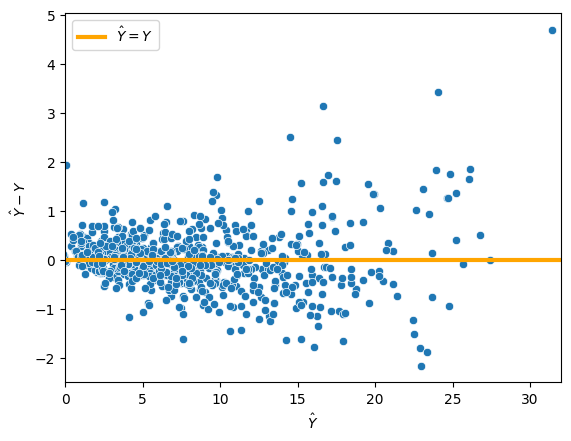

In [16]:
sns.scatterplot(x = Y_hat.flatten(), y = (Y - Y_hat).flatten())
sns.lineplot(x=[-1, 35], y=[0,0], label="$\hat{Y}=Y$", color = 'orange', linewidth = 3)
plt.xlabel("$\hat{Y}$")
plt.ylabel("$\hat{Y} - Y$")
plt.xlim([0, 32])
plt.show()

Overall while the residuals are roughly centered around 0 ($\hat{y} = y$), we see **heteroskedasticity**: Our regression spread is uneven, particularly as predictions get big.

## Multiple $R^2$

Let's compute the coefficient of determination, or **multiple $R^2$**, for our model.

In [17]:
r2_ast_fg_3pa = np.var(Y_hat) / np.var(Y)
r2_ast_fg_3pa

np.float64(0.9883162128703241)

That's super high!!! Wait, what's up with that?

(Hint: Basketball facts)

Let's try reducing the number of features to see how this Multiple $R^2$ metric changes.

In [18]:
# Use intercept, AST, 3PA
X_3d = nba[['AST', '3PA']]
X_3d.insert(0, 'Bias', 1)
X_3d = X_3d.to_numpy()

theta_ast_3pa = least_squares_estimate(X_3d, Y)
Y_hat_ast_3pa = X_3d @ theta_ast_3pa

r2_ast_3pa = np.var(Y_hat_ast_3pa) / np.var(Y)
r2_ast_3pa

np.float64(0.6087862763665719)

In [19]:
# Use intercept, AST only (SLR)
X_slr = nba[['AST']]
X_slr.insert(0, 'Bias', 1)
X_slr = X_slr.to_numpy()

theta_ast_only = least_squares_estimate(X_slr, Y)
Y_hat_ast_only = X_slr @ theta_ast_only

r2_ast_only = np.var(Y_hat_ast_only) / np.var(Y)
r2_ast_only

np.float64(0.4570055507968593)

In [20]:
theta_ast_only

array([[3.98332315],
       [2.39888152]])

In [21]:
theta_hat

array([[-0.29253798],
       [ 2.51705703],
       [ 0.05075571],
       [ 0.31307653]])

Comparing these Multiple $R^2$ together:

In [22]:
print("(SLR) intercept, AST:    ", r2_ast_only)
print("intercept, 3PA, AST:     ", r2_ast_3pa)
print("intercept, FG, 3PA, AST: ", r2_ast_fg_3pa)

(SLR) intercept, AST:     0.4570055507968593
intercept, 3PA, AST:      0.6087862763665719
intercept, FG, 3PA, AST:  0.9883162128703241


Because of how basketball is scored, knowing Field Goals `FG` *and* 3 point goal attempts `3PA` will reliably tell you how many total points a player scored in that game. This is assuming NBA players make a good number of their 3-pointers.

Side note, if you wanted to check that Multiple R^2 for Simple Linear Regression is indeed correlation coefficient $r^2$:

In [23]:
r = np.corrcoef(nba['AST'], nba['PTS'])[0,1]
r ** 2

np.float64(0.4570055507968598)